Specify your word frequency data in a collection a Google Spreadsheets, and provide the `alphanumeric id` shown in the URL.

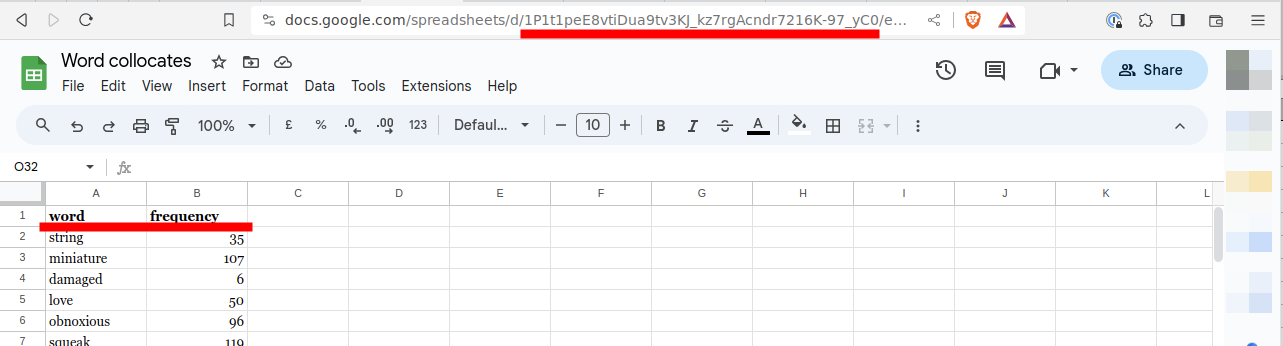

Create a seperate sheet for each node and one for shared collocates. All sheets should have a `word` and `frequency` column.

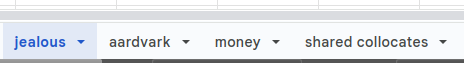

Run the algorithm:

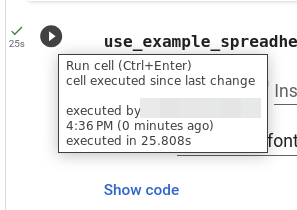

And wait for a bit:

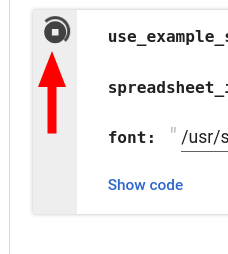

Check for potential error messages, e.g. in this case the spreadsheet doesn't exist. Other issues could be related to a false data format or a bug.

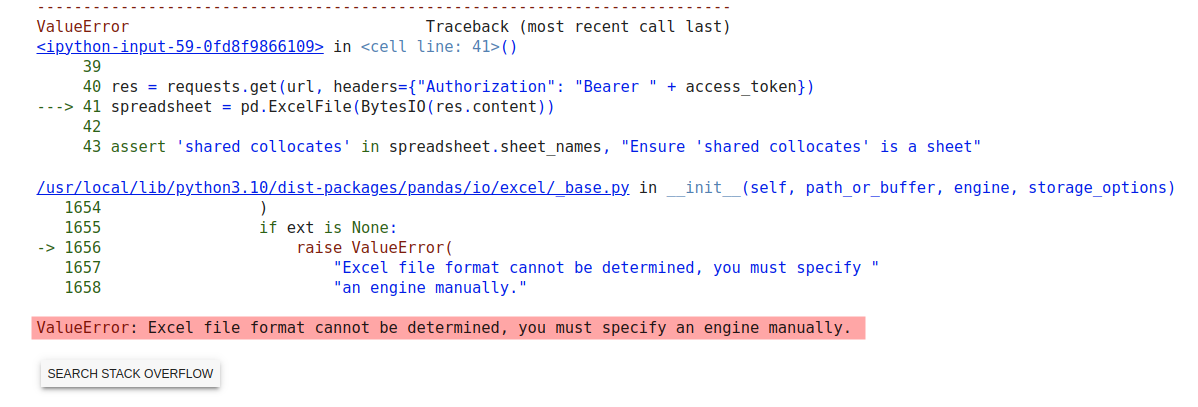

In [ ]:
#@markdown #@markdown # Create wordcloud graph from word frequencies

use_example_spreadheet = 'other example' #@param ['reproduction of paper', 'other example', 'custom']

custom_spreadsheet_id = '' #@param {"type": "string"}

font = '/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf' #@param {"type": "string"}

assert custom_spreadsheet_id.strip() == "" or use_example_spreadheet == "custom", "Select custom or leave `custom_spreadsheet_id` empty"
spreadsheet_id = {
    'custom': custom_spreadsheet_id,
    'reproduction of paper': '1ppSh3v6OHi9SebptOYm-3lc87hnd1yPSG3Gie7J1cZ0',
    'other example': '1P1t1peE8vtiDua9tv3KJ_kz7rgAcndr7216K-97_yC0',
}.get(use_example_spreadheet)

import os
import sys
import requests
from io import BytesIO

import numpy as np
import pandas as pd
from wordcloud import WordCloud

from skimage.morphology import dilation, disk
from skimage.draw import line
from skimage.io import imsave

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from IPython.display import Image

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()

url = f"https://docs.google.com/spreadsheets/export?id={spreadsheet_id}&exportFormat=xlsx"
access_token = gauth.attr['credentials'].get_access_token().access_token

res = requests.get(url, headers={"Authorization": "Bearer " + access_token})
spreadsheet = pd.ExcelFile(BytesIO(res.content))

assert 'shared collocates' in spreadsheet.sheet_names, "Ensure 'shared collocates' is a sheet"

words = [word for word in spreadsheet.sheet_names if word != 'shared collocates']
nodes = pd.concat(list(map(spreadsheet.parse, words)), keys=words, names=['node'])
shared = spreadsheet.parse('shared collocates')

assert len({'word', 'frequency'} - set(nodes.columns)) == 0, "Ensure 'word' and 'frequency' columns in all sheets"
assert nodes[['word', 'frequency']].isna().sum().sum() == 0, "Ensure 'word' and 'frequency' columns in all sheets without empty values"
assert len({'word', 'frequency'} - set(shared.columns)) == 0, "Ensure 'word' and 'frequency' columns in 'shared collocates'"

nodes = nodes.groupby('node').apply(lambda x: x.set_index('word')['frequency'].to_dict()).to_dict()
shared = shared.set_index('word')['frequency'].to_dict()

# Create masks for the different word-cloud areas, and the surrounding

#radii for the inner cluster, and the inner and outer arcs of the outer clusters.
r0_, r1_, r2_ = 0.3, 0.6, 0.9

r0, r1, r2 = r0_**2, r1_**2, r2_**2

# Mask to be used by `wordcloud`, 0 == background, 1 == center cluster
 #(shared collocates), 2... == outer clusters.
mask = np.zeros((2000, 2000), dtype=int)

x = np.linspace(-1, 1, mask.shape[0])[:, None]
y = np.linspace(-1, 1, mask.shape[1])[None]

mask[(x ** 2 + y ** 2) < r0] = 1
outer = ((x ** 2 + y ** 2) > r1) & ((x ** 2 + y ** 2) < r2)
angle = np.arctan2(x, y)
angle = ((angle + 0.3 + np.pi) % (2*np.pi)) - np.pi

r3 = (r1 + r2) / 2 - 10/2000
r4 = r3+20/2000
arcs = np.zeros(mask.shape)
lines = np.zeros(mask.shape)

# Calculating angles at which to position outer clusters.
# outer cluster size based on words in cluster
m = np.mean([sum(v.values()) for v in nodes.values()]) / 5
radii = [0] + [m+sum(v.values()) for v in nodes.values()]

# inject space between outer clusters, partially based on the average cluster
# size m and partially based on the particular cluster size (to avoid super-
# small cluster areas).
radii = np.cumsum([x for x in zip(
    radii, [np.mean(radii[1:])/3] * len(radii)) for x in x])[:-1]
# convert to radians between -pi and pi.
radii /= radii.max() / 2 / np.pi
radii -= np.pi

# Create outer clusters and draw arcs towards center cluster
for i, (a0, a1) in enumerate(zip(radii[1::2], radii[2::2]), start=2):
  # mark the designated angle-span on the outer circle
  piece = (angle > a0) & (angle < a1)
  mask[outer & piece] = i
  # Draw arc between inner and outer cluster `i`
  a = (a0 + a1) / 2
  x_, y_ = np.sin(a), np.cos(a)
  x_, y_ = line(*(np.array([x_ * r0_, y_ * r0_, x_ * r1_, y_*r1_]).reshape(2,2) * 2000 / 2 + 2000/2).ravel().round().astype(int))
  lines[x_, y_] = 1

# draw arcs between adjacent outer clusters
outer_ = ((x ** 2 + y ** 2) > r3) & ((x ** 2 + y ** 2) < r4)
for a0, a1 in zip(radii[::2], radii[1::2]):
  piece = (angle > a0) & (angle < a1)
  arcs[outer_ & piece] = 1

# Thicken line a bit, instead of a single-pixel was.
lines = dilation(lines, disk(3))
#join arcs between outer and with inner cluster(s)
arcs = (arcs > 0) | (lines > 0)

# add borders for all clusters
edges = dilation(mask > 0, disk(10))
arcs &= ~dilation(edges, disk(10))
edges = dilation(edges, disk(10)) & ~edges

# color the arcs dark gray
arcs = 255 - arcs[..., None] * [[[150, 150, 150]]]

# color the edges black
edges = 255 - edges[..., None] * [[255, 255, 255]]
edges = edges.astype(np.uint8)
arcs = arcs.astype(np.uint8)

# cluster borders and arcs
outlines = np.minimum(edges, arcs)

# draw the all words gray except for the central word of the cluster:
def color_func(word_):
  def f(word, font_size, position, orientation, font_path, random_state):
    nonlocal word_
    return '#000000' if word == word_ else '#888888'
  return f

# central cluster (shared collocates)
image = WordCloud(
    background_color='white', color_func=color_func(None),
    font_path=font, mask = (255 * (mask != 1)).astype(np.uint8)
).generate_from_frequencies(shared)


# all other cluster:
for i, (word, text) in enumerate(nodes.items(), start=2):
  wordcloud = WordCloud(
      background_color='white', font_path=font,
      mask = (255 * (mask != i)).astype(np.uint8),
      color_func=color_func(f' {word} '),
  ).generate_from_frequencies(dict(**text, **{f' {word} ': max(text.values())}))
  image = np.minimum(image, wordcloud)

# combine word clouds, arcs and borders
image = np.minimum(image, outlines)

imsave('result.png', image)
Image('result.png')